# COURSE: A deep understanding of deep learning
## SECTION: Autoencoders
### LECTURE: AEs for occlusion
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202108

In [2]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import copy

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-2-804db5fc3c03>:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process the data

In [16]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# don't need labels
labels = data[:,0]
data = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# convert to tensor
dataT = torch.tensor( dataNorm ).float()

# Demonstration of implementing occlusion

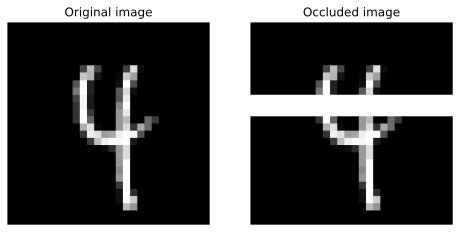

In [4]:
# reconstruct a sample as an image

img = dataT[12345,:].view(28,28)


occluded = copy.deepcopy( img )
occluded[10:13,:] = 1

fig,ax = plt.subplots(1,2,figsize=(8,5))

ax[0].imshow(img,cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(occluded,cmap='gray')
ax[1].set_title('Occluded image')
ax[1].axis('off')

plt.show()

# Create the DL model

In [82]:
# create a class for the model
def createTheMNISTAE():

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,128)

      ### encoder layer
      self.enc = nn.Linear(128,50)

      ### latent layer
      self.lat = nn.Linear(50,128)

      ### decoder layer
      self.dec = nn.Linear(128,784)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.enc(x) )
      x = F.relu( self.lat(x) )
      y = torch.sigmoid( self.dec(x) )
      return y

  # create the model instance
  net = aenet()

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

# Create a function that trains the model

In [83]:
def function2trainTheModel():

  # number of epochs
  numepochs = 5

  # create a new model
  net,lossfun,optimizer = createTheMNISTAE()

  # initialize losses
  losses = []



  # batch size and number of batches
  batchsize  = 32
  numBatches = int(dataT.shape[0]/batchsize)


  # loop over epochs (now each epoch goes through all samples)
  for epochi in range(numepochs):


    # get a permuted index vector
    randidx = np.random.permutation(dataT.shape[0]).astype(int)

    for batchi in range(numBatches):

      # samples to use in this batch
      samps2use = range((batchi-1)*batchsize,batchi*batchsize)


      # select those images
      X = dataT[randidx[samps2use],:]

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      # losses in this batch
      losses.append( loss.item() )

  # end epochs

  # function output
  return losses,net

# Run the model and show the results!

Final loss: 0.0126


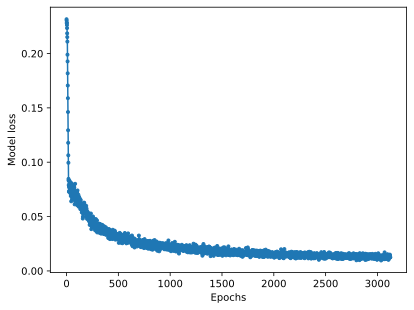

In [84]:
# train the model (16s)
losses,net = function2trainTheModel()
print(f'Final loss: {losses[-1]:.4f}')

# visualize the losses
plt.plot(losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.show()

# Add occlusion to some images

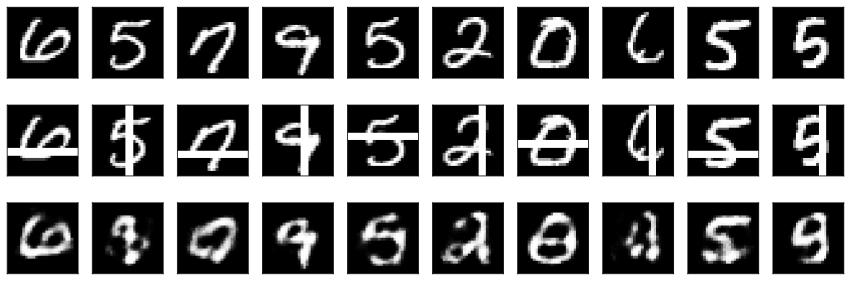

In [18]:
# grab a small set of images
X = copy.deepcopy( dataT[:10,:] )

# add noise
for i in range(X.shape[0]):

  # reshape the image
  img = X[i,:].view(28,28)

  # occlude random rows or columns
  startloc = np.random.choice(range(10,21))
  if i%2==0: # even -> horizontal occlusion
    img[startloc:startloc+1,:] = 1
  else:      # odd -> vertical occlusion
    img[:,startloc:startloc+1] = 1



# run the samples through the model
deOccluded = net(X)


# show the noisy images
fig,axs = plt.subplots(3,10,figsize=(15,5))

for i in range(10):
  axs[0,i].imshow(dataT[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[2,i].imshow(deOccluded[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  axs[2,i].set_xticks([]), axs[2,i].set_yticks([])

plt.show()

# Something more quantitative

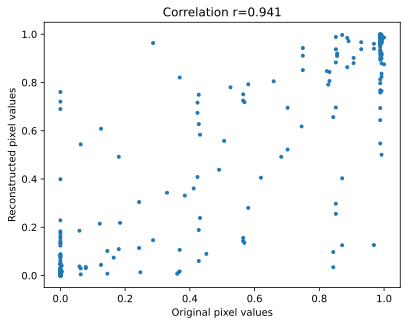

In [9]:
# We can quantify the performance of our "de-occluder" by correlating the sample with the original.

inOutCorr = np.corrcoef(dataT[9,:].detach(),deOccluded[9,:].detach())

# and plot
plt.plot(dataT[9,:].detach(),deOccluded[9,:].detach(),'.')
plt.xlabel('Original pixel values')
plt.ylabel('Reconstructed pixel values')
plt.title(f'Correlation r={ inOutCorr[0,1] :.3f}')
plt.show()

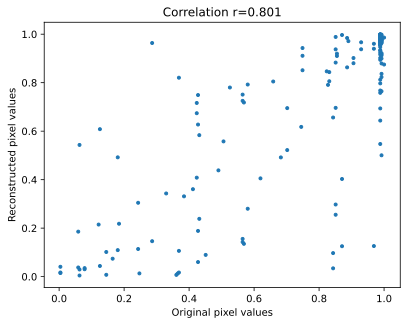

In [10]:
# try again without the zero-valued pixels

# extract to variables for convenience
orig  = dataT[9,:].detach()
recon = deOccluded[9,:].detach()

# boolean vector that indicates pixels>0 (with some tolerance)
tol = 1e-4
nonzeropixels = (orig>tol) & (recon>tol)

# then re-compute the correlation
inOutCorr = np.corrcoef(orig[nonzeropixels],recon[nonzeropixels])

# redraw the previous plot
plt.plot(orig[nonzeropixels],recon[nonzeropixels],'.')
plt.xlabel('Original pixel values')
plt.ylabel('Reconstructed pixel values')
plt.title(f'Correlation r={ inOutCorr[0,1] :.3f}')
plt.show()

In [69]:
ce =  [[c for c in range(100)] for i in range(10) ]
for j in range(10):
  # print(j)
  dat = data[labels == j ][:100]
  ce[j]= dat

<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-69-c36891c5a2f8>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
  np.sum((ce[1]is 0))


0

In [ ]:
 # get data with no occlusion


noOcclusion = net(dataT[:10,:])

# compare deOccluded-original to noOcclusion-original correlation
r = np.zeros((10,2))
for i in range(deOccluded.shape[0]):

  # pixel selection (note: tolerance defined in previous cell)
  nonzeropixels = (dataT[i,:]>tol) & (noOcclusion[i,:]>tol) & (deOccluded[i,:]>tol)

  # now compute the correlations
  r[i,0] = np.corrcoef(dataT[i,nonzeropixels].detach(),noOcclusion[i,nonzeropixels].detach())[0,1]
  r[i,1] = np.corrcoef(dataT[i,nonzeropixels].detach(),deOccluded[i,nonzeropixels].detach())[0,1]


# plot the correlation coefficients
plt.plot(r,'o',markersize=10)
plt.legend(['No occlusion','Occlusion'])
plt.xlabel('Sample number')
plt.ylabel('Correlation with original')
plt.show()

In [89]:


correl = []
r = np.zeros((10,2))
for j in range(10):
  dataT_c =dataT[labels == j]
  r = np.zeros((10,2))
  noOcclusion = net(dataT_c)
  for i in range(deOccluded.shape[0]):

    # pixel selection (note: tolerance defined in previous cell)
    nonzeropixels = (dataT_c[i,:]>tol) & (noOcclusion[i,:]>tol) & (deOccluded[i,:]>tol)

    # now compute the correlations
    r[i,0] = np.corrcoef(dataT_c[i,nonzeropixels].detach(),noOcclusion[i,nonzeropixels].detach())[0,1]
    r[i,1] = np.corrcoef(dataT_c[i,nonzeropixels].detach(),deOccluded[i,nonzeropixels].detach())[0,1]
  print(r)

[[ 0.74166572 -0.02457183]
 [ 0.88954828 -0.02219734]
 [ 0.68946999  0.04809635]
 [ 0.71708599 -0.1193632 ]
 [ 0.86836081  0.01910366]
 [ 0.8831898  -0.06833382]
 [ 0.60441534 -0.00455331]
 [ 0.88092187 -0.12541945]
 [ 0.90691794  0.14134755]
 [ 0.85605272 -0.14934292]]
[[ 9.05229773e-01  1.57392821e-01]
 [ 9.28383124e-01  1.72305656e-01]
 [ 9.49666809e-01  4.92259661e-04]
 [ 8.29299852e-01 -1.07484789e-01]
 [ 8.04044750e-01 -1.03856822e-01]
 [ 9.52163746e-01 -9.98639013e-03]
 [ 9.61889809e-01  9.94277281e-02]
 [ 8.42398586e-01 -1.69226718e-02]
 [ 9.26383077e-01  2.09954427e-01]
 [ 6.78534733e-01 -7.53199188e-02]]
[[ 0.66857721 -0.09446657]
 [ 0.75106692  0.29903456]
 [ 0.75626197  0.0501071 ]
 [ 0.80502473  0.06519896]
 [ 0.62923324 -0.03082155]
 [ 0.85338646 -0.17110087]
 [ 0.52788229 -0.25062122]
 [ 0.83778338  0.18346188]
 [ 0.57604438  0.14691865]
 [ 0.67595127  0.03741418]]
[[ 0.83046031 -0.05092467]
 [ 0.70656963  0.14819092]
 [ 0.52839816  0.05430568]
 [ 0.82691163  0.09501925]

In [134]:
noOcclusion = net(dataT_c)
noOcclusion1=noOcclusion.detach().numpy()
for i in range(noOcclusion.shape[0]):
  noOcclusion1[i,:]  = np.int32((noOcclusion1[i,:] > 0.5))


# noOcclusion

data_cc = dataT_c.detach().numpy()
for i in range(noOcclusion1.shape[0]):
  data_cc[i,:]  = np.int32((data_cc[i,:] > 0.5))
np.sum(data_cc) / np.sum(noOcclusion1)

0.9774575

In [135]:
themse =[]
for i in range(noOcclusion1.shape[0]):
  themse.append(np.sum((data_cc[i,:]- noOcclusion1[i,:])**2)/ noOcclusion1.shape[0])
thebest =np.argmin(themse)

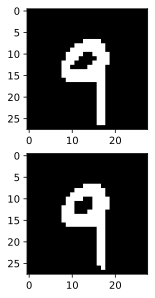

In [136]:
fig,ax =plt.subplots(2,1)

ax[0].imshow(dataT_c[thebest,:].view(28,28).detach() ,cmap='gray')
ax[1].imshow(noOcclusion[thebest,:].view(28,28).detach() ,cmap='gray')

# Additional explorations

In [ ]:
# 1) Does occlusion affect some numbers more than others? Run the entire dataset through the autoencoder with occluded
#    images. Compute the image correlations for each sample. Then compute the average correlation for each number (image
#    label). Show the results in a plot. (Bonus: Also compute the standard deviation across correlations and use those
#    to draw error bars.) What do the results tell you about the difficulty of fixing occlusions in images?
#
# 2) Perhaps a correlation coefficient isn't really the best performance metric. Try this: Binarize the images like we
#    did in the video "CodeChallenge: Binarized MNIST images" (section FFN). Then compute the number of pixels in the
#    original and reconstructed images that overlap (hint: try summing them). Make sure your new metric has a possible
#    range of 0 (absolutely no overlap) to 1 (perfect overlap). Does this metric seem more consistent with your visual
#    intuition?
#
# 3) But wait a minute, don't we already have a quantitative measure of the similarity between the AE input and output?
#    Of course we do -- it's the loss function! Mean-squared error already accounts for zeros because those get ignored
#    [zero-valued pixels have MSE=(0-0)**2 ]. In fact, question #2 is kindof a "rough MSE." Take a moment to write down
#    the formulas for MSE and correlation, and see whether they are related (hint: the relationship isn't linear because of
#    the squared term). Finally, compute MSE on our example occlusion images and compare MSE to correlation empirically
#    by making a scatter plot. (Hint 1: Use more than 10 examples to see trends. Hint 2: Consider the signs (+/-).)
#
# Note about exercises 2&3: MSE really is the best loss function for this problem. The purpose of these exercises is to
#    get you thinking critically about autoencoders, loss functions, and the idea of using custom-designed quantitative
#    comparisons measures. I hope you find these problems enjoyable and thought-provoking!
#